# CONVOLUTIONAL NEURAL NETWORK for detecting vehicles in an image using TensorFlow

Dataset yang digunakan untuk model ini berasal dari Vehicle Detection Image Set di Kaggle.

1. Penjelasan Dataset:
  * Kategori Gambar:
    * non-vehicles: Images containing vehicles.<br>
    * vehicles: Images not containing vehicles.<br>

  * Jumlah Gambar:
    * Total ada 17,760 gambar dalam dataset ini.

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import random

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

## Langkah 1. Evaluasi Dataset.
* Jenis file: Pastikan semua file yang digunakan adalah file gambar (misalnya JPG atau PNG).

* Resolusi gambar: Periksa resolusi gambar-gambar dalam dataset untuk menentukan apakah perlu diskalakan atau diseragamkan.

* Visualisasi: Tampilkan beberapa gambar secara acak dari masing-masing kelas (kendaraan dan bukan kendaraan) untuk memastikan kualitas dan relevansi data.

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saniyyahzhafirah","key":"3fe82b3ee88685d986bb9ccc00442581"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d brsdincer/vehicle-detection-image-set
!unzip vehicle-detection-image-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

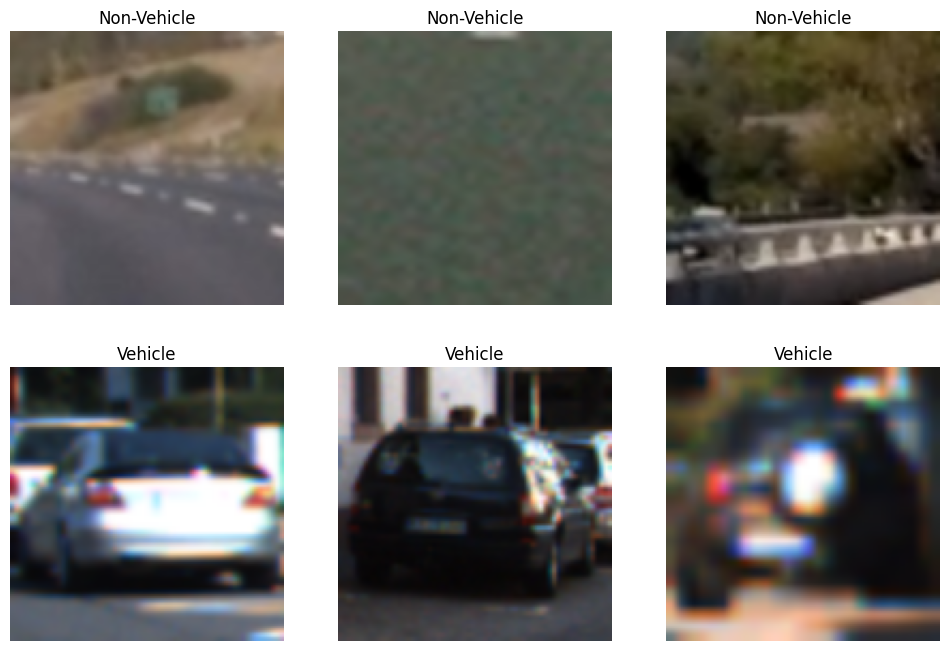

In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Fungsi untuk load dan preprocess gambar
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Ganti ukuran gambar ke 128x128
    image = image / 255.0
    return image

# Menentukan subfolder untuk vehicle dan non-vehicle
subfolder = ['non-vehicles', 'vehicles']
directory_path = 'data'  # Path ke folder yang sudah diekstrak

# Flag untuk visualisasi
VISUALIZE = True

if VISUALIZE:
    plt.figure(figsize=(12, 8))
    for j, subfolder_name in enumerate(subfolder):
        folder_path = os.path.join(directory_path, subfolder_name)

        # Check if the folder exists before attempting to list its contents
        if os.path.exists(folder_path):
            image_files = random.sample(os.listdir(folder_path), 3)

            for i, image_file in enumerate(image_files):
                image_path = os.path.join(folder_path, image_file)
                image = load_and_preprocess_image(image_path).numpy()

                plt.subplot(2, 3, j * 3 + i + 1)
                plt.imshow(image)
                plt.title('Vehicle' if subfolder_name == 'vehicles' else 'Non-Vehicle')
                plt.axis('off')
        else:
            print(f"Warning: Folder '{folder_path}' not found. Skipping.")

    plt.show()


## Langkah 2. Persiapan Dataset dan Augmentasi Gambar


In [ ]:
# Variables to store total counts
m_nonvehicles = 0
m_vehicles = 0

split_test = 0.2
split_valid = 0.2

# Count images in each category
subfolder = ['non-vehicles', 'vehicles']
for subfolder in subfolder:
    path = os.path.join(directory_path, subfolder)
    if os.path.exists(path):
        if subfolder == 'non-vehicles':
            m_nonvehicles = len(os.listdir(path))
        elif subfolder == 'vehicles':
            m_vehicles = len(os.listdir(path))

m = m_nonvehicles + m_vehicles
n_test = round(m * split_test)
n_train = round((m - m * split_test) * (1 - split_valid))
n_valid = round((m - m * split_test) * (split_valid))

n_test_non = round(m_nonvehicles * split_test)
n_train_non = round(m_nonvehicles * (1 - split_test) * (1 - split_valid))
n_valid_non = round(m_nonvehicles * (1 - split_test) * (split_valid))

n_test_vehicle = round(m_vehicles * split_test)
n_train_vehicle = round(m_vehicles * (1 - split_test) * (1 - split_valid))
n_valid_vehicle = round(m_vehicles * (1 - split_test) * (split_valid))

print(f"Number of images in the dataset: {m}\n")
print('-'* 73)
print(f"{'Category':<20}{'Total':<10}{'Train':<10}{'Validate':<10}{'Test':<10}{'Test Split(%)':<10}")
print('-'* 73)
print(f"{'Non-vehicle':<20}{m_nonvehicles:<10}{n_train_non:<10}{n_valid_non:<10}{n_test_non:<10}{n_test_non/(n_valid_non+n_train_non+n_test_non):<4.4}")
print(f"{'Vehicle':<20}{m_vehicles:<10}{n_train_vehicle:<10}{n_valid_vehicle:<10}{n_test_vehicle:<10}{n_test_vehicle/(n_valid_vehicle+n_train_vehicle+n_test_vehicle):<4.4}")
print('-'* 73)
print(f"{'':<20}{m:<10}{n_train:<10}{n_valid:<10}{n_test:<10}{n_test/(n_valid+n_train+n_test):<4.4}")

Number of images in the dataset: 17760

-------------------------------------------------------------------------
Category            Total     Train     Validate  Test      Test Split(%)
-------------------------------------------------------------------------
Non-vehicle         8968      5740      1435      1794      0.2 
Vehicle             8792      5627      1407      1758      0.2 
-------------------------------------------------------------------------
                    17760     11366     2842      3552      0.2 


In [ ]:
vehicle_dir = os.path.join(directory_path, 'vehicles')
non_vehicle_dir = os.path.join(directory_path, 'non-vehicles')

vehicle_files = [os.path.join(vehicle_dir, f) for f in os.listdir(vehicle_dir)]
non_vehicle_files = [os.path.join(non_vehicle_dir, f) for f in os.listdir(non_vehicle_dir)]

# Create labels
vehicle_labels = ["1"] * len(vehicle_files)
non_vehicle_labels = ["0"] * len(non_vehicle_files)

# Combine data
all_files = vehicle_files + non_vehicle_files
all_labels = vehicle_labels + non_vehicle_labels

# Split into training and test sets (0.2 test split)
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)

# Create dataframes for train, validation, and test data
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})

# Further split training data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'], train_df['class'], test_size=0.2, random_state=42)

val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

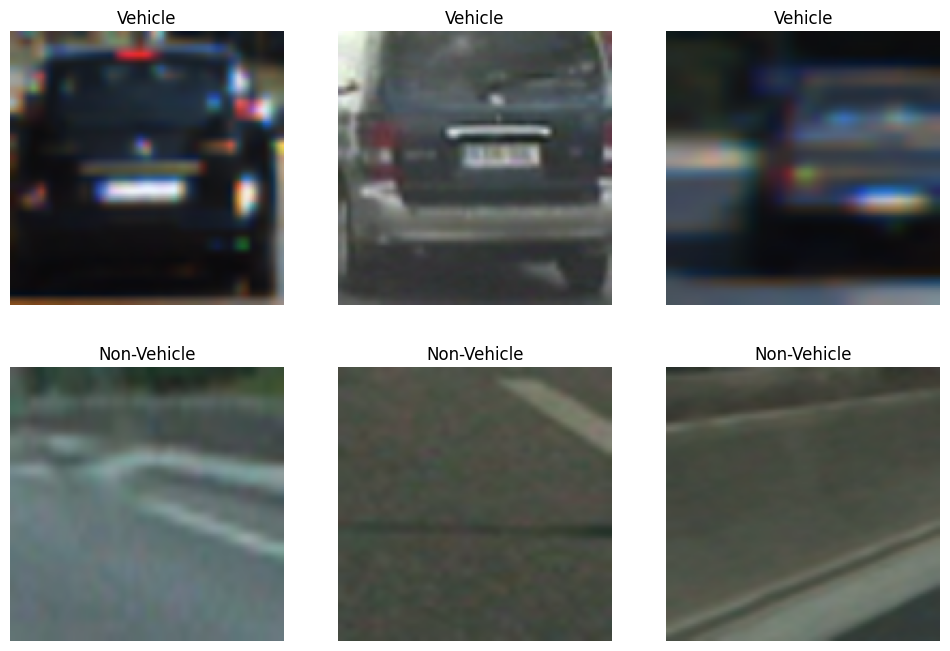

In [ ]:
# Confirm that the images were labeled correctly
plt.figure(figsize=(12, 8))
for i, idx in enumerate([1,3,5,2,4,9]):
    image_path = train_files[int(idx)]
    label = int(train_labels[idx])
    image = load_and_preprocess_image(image_path).numpy()

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title('Vehicle' if label == 1 else 'Non-Vehicle')
    plt.axis('off')

plt.show()

In [ ]:
# ImageDataGenerator for train set with augmented data
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for test set
datagen_test = ImageDataGenerator(
    rescale=1./255
)

# Create training data generator
train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64), #maintaining the data resolution since it is small
    batch_size=32,
    class_mode='binary',
    seed=42 #of course
)

# Create validation data generator
validation_generator = datagen_train.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    seed=42
)

# Create test data generator
test_generator = datagen_test.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    seed=42
)

Found 14208 validated image filenames belonging to 2 classes.
Found 2842 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


## Langkah 3: Membangun, Melatih, dan Mengevaluasi Model CNN


In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
import tensorflow as tf

# Define CNN model
cnn = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Save model weights after each epoch
model_checkpoint = ModelCheckpoint(
    'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

# Compile the model
cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Start training timer
start_time = time.time()

# Train the model without early stopping or custom accuracy stopping
history = cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[model_checkpoint]
)

# Show training time
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training Time: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

# Evaluate on the test set
test_loss, test_acc = cnn.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7739 - loss: 0.4338
Epoch 1: saving model to model_epoch_01_val_loss_0.16.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.7741 - loss: 0.4335 - val_accuracy: 0.9458 - val_loss: 0.1600
Epoch 2/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9358 - loss: 0.1744
Epoch 2: saving model to model_epoch_02_val_loss_0.20.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9358 - loss: 0.1744 - val_accuracy: 0.9222 - val_loss: 0.1992
Epoch 3/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9510 - loss: 0.1389
Epoch 3: saving model to model_epoch_03_val_loss_0.11.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9510 - loss: 0.1389 - val_accuracy: 0.9606 - val_loss: 0.1114
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9604 - loss: 0.1095
Epoch 4: saving model to model_epoch_04_val_loss_0.09.weights.h5
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 68

In [ ]:
# Simpan model lengkap
cnn.save('best_model.keras')

## Langkah 4: Visualisasi Loss dan Evaluasi Model Terbaik

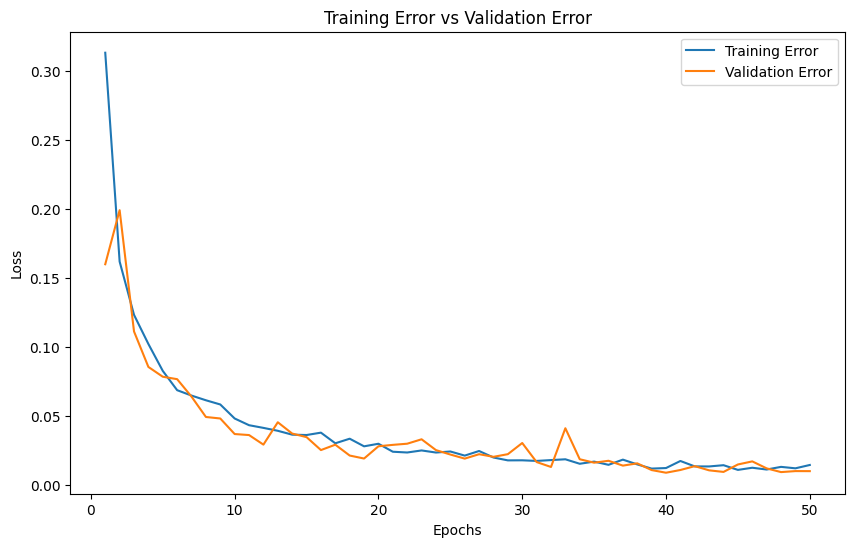

In [ ]:
# Extracting loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training error vs validation error
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Error')
plt.plot(epochs, val_loss, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error vs Validation Error')
plt.legend()
plt.show()

In [ ]:
# Load the best model
cnn = load_model('best_model.keras')

# Evaluate the model on the test set
test_loss, test_acc = cnn.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9938 - loss: 0.0171
Test Loss: 0.0156
Test Accuracy: 0.9947


## Langkah 5: Prediksi dan Visualisasi Klasifikasi Gambar Kendaraan Menggunakan Model TensorFlow

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Prediction: Vehicle (1.0000)


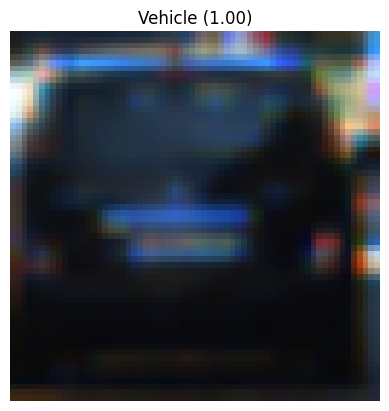

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction: Non-Vehicle (0.0000)


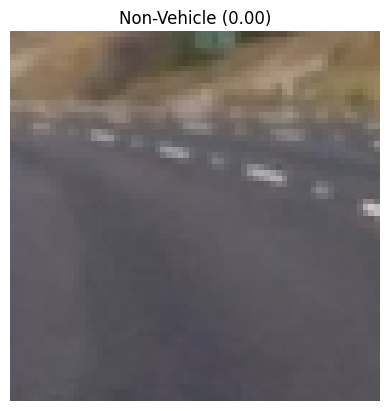

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Fungsi prediksi + visualisasi
def predict_image(image_path, model):
    # Cek apakah file ada
    if not os.path.exists(image_path):
        print(f"File {image_path} tidak ditemukan!")
        return

    # Muat dan proses gambar
    img = image.load_img(image_path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(x)[0][0]
    label = "Vehicle" if prediction > 0.5 else "Non-Vehicle"

    # Tampilkan hasil prediksi
    print(f"Prediction: {label} ({prediction:.4f})")

    # Visualisasi gambar dengan label prediksi
    plt.imshow(img)
    plt.title(f"{label} ({prediction:.2f})")
    plt.axis('off')
    plt.show()

# Memuat model terbaik
model = load_model('best_model.keras')  # Ganti dengan nama model yang tepat

# Contoh pemanggilan untuk vehicle
predict_image('data/vehicles/1580.png', model)  # Ganti dengan path gambar kendaraan

# Contoh pemanggilan untuk non-vehicle
predict_image('data/non-vehicles/extra1058.png', model)  # Ganti dengan path gambar non-kendaraan
